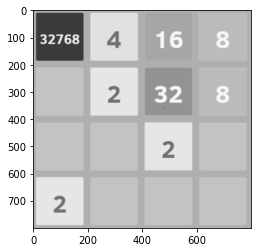

In [283]:
import skimage
import skimage.io
import skimage.color
import skimage.measure
import skimage.feature
import skimage.filters
import skimage.transform
import pytesseract
import imutils
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
img = skimage.io.imread("2048-2.png")
img = skimage.color.rgb2gray(img[:,:,0:3])
h = 800
w = 800
img = skimage.transform.resize(img, (h, w))

plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(img, cmap="gray", vmin=0, vmax=1.0)


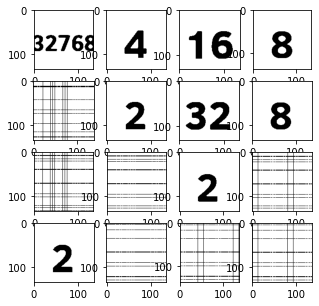

[[32768     4    16     8]
 [    0     2    32     0]
 [    0     0     2     0]
 [    2     0     0     0]]


In [287]:

plt.rcParams['figure.figsize'] = [5, 5]
fig, axs = plt.subplots(nrows=4, ncols=4)

numbers = np.zeros((4,4), dtype="int")

for i in range(4):
    for j in range(4):
            
        h = img.shape[0] 
        w = img.shape[1]
        
        y1 = int(h/4.0*i)
        y2 = int(h/4.0*(i+1))
        x1 = int(w/4.0*j)
        x2 = int(w/4.0*(j+1))
            
        crop = img[y1:y2, x1:x2]
        edge = skimage.feature.canny(crop, sigma=2.5, high_threshold=0.01, low_threshold=0.01)
        
        for k in range(0, edge.shape[1], 1):
            if(edge[edge.shape[0]//2,k]):
                y1 = k+crop.shape[0]//10
                break
        for k in range(0, edge.shape[0], 1):
            if(edge[k, edge.shape[0]//2]):
                x1 = k+crop.shape[1]//10
                break
        for k in range(edge.shape[1]-1, -1, -1):
            if(edge[edge.shape[0]//2,k]):
                y2 = k-crop.shape[0]//10
                break   
        for k in range(edge.shape[0]-1, -1, -1):
            if(edge[k, edge.shape[0]//2]):
                x2 = k-crop.shape[1]//10
                break
        
        crop = crop[y1:y2, x1:x2]
        thresh = skimage.filters.threshold_otsu(crop)
        crop = ((crop > thresh)*255).astype("uint8")
        
        if(np.mean(crop) < 128):
            crop = 255 - crop
        elif(np.mean(crop) > 250):
            crop = np.ones_like(crop)*255
        
        """
        mask = crop < 128
        m,n = img.shape
        mask0, mask1 = mask.any(0), mask.any(1)
        col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
        row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
        crop = crop[row_start:row_end,col_start:col_end]
        """
        
        axs[i,j].imshow(crop, cmap="gray", vmin=0, vmax=255)
        
        number = pytesseract.image_to_string(crop, config=' --psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
        if(number != ""):
            numbers[i,j] = int(number)
        
plt.show()

print(numbers)

In [288]:
from __future__ import print_function
import ctypes
import time
import os
import math

MULTITHREAD = True

for suffix in ['so', 'dll', 'dylib']:
    dllfn = 'bin/2048.' + suffix
    if not os.path.isfile(dllfn):
        continue
    print(dllfn)
    ailib = ctypes.CDLL(dllfn)
    break
else:
    print("Couldn't find 2048 library bin/2048.{so,dll,dylib}! Make sure to build it first.")
    exit()

ailib.init_tables()
ailib.find_best_move.argtypes = [ctypes.c_uint64]
ailib.score_toplevel_move.argtypes = [ctypes.c_uint64, ctypes.c_int]
ailib.score_toplevel_move.restype = ctypes.c_float

def to_c_board(m):
    board = 0
    i = 0
    for row in m:
        for c in row:
            board |= int(c) << (4*i)
            i += 1
    return board

def print_board(m):
    for row in m:
        for c in row:
            print('%8d' % c, end=' ')
        print()

def _to_val(c):
    if c == 0: return 0
    return 2**c

def to_val(m):
    return [[_to_val(c) for c in row] for row in m]

def _to_score(c):
    if c <= 1:
        return 0
    return (c-1) * (2**c)

def to_score(m):
    return [[_to_score(c) for c in row] for row in m]
        
if MULTITHREAD:
    from multiprocessing.pool import ThreadPool
    pool = ThreadPool(4)
    def score_toplevel_move(args):
        return ailib.score_toplevel_move(*args)

    def find_best_move(m):
        board = to_c_board(m)

        print_board(to_val(m))

        scores = pool.map(score_toplevel_move, [(board, move) for move in range(4)])
        bestmove, bestscore = max(enumerate(scores), key=lambda x:x[1])
        if bestscore == 0:
            return -1
        return bestmove
else:
    def find_best_move(m):
        board = to_c_board(m)
        return ailib.find_best_move(board)

board = numbers.tolist()
print(board)
for i in range(4):
    for j in range(4):
        tval = board[i][j]
        if(tval == 0):
            board[i][j] = 0
        else:
            board[i][j] = int(round(math.log(tval, 2)))
print(board)

move = find_best_move(board)
print(move)


bin/2048.dll
[[32768, 4, 16, 8], [0, 2, 32, 0], [0, 0, 2, 0], [2, 0, 0, 0]]
[[15, 2, 4, 3], [0, 1, 5, 0], [0, 0, 1, 0], [1, 0, 0, 0]]
   32768        4       16        8 
       0        2       32        0 
       0        0        2        0 
       2        0        0        0 
3
